In [1]:
#Project on Heart Disease

In [9]:
#Prav Cells Below (helps out with reducing errors)

#Introduction

Introduction:
Heart disease is a broad term that refers to different heart conditions. Something in common is their effect on blood flow and dilation of veins to the heart. Other factors such as age, sex, and exercise are factors that are closely linked with heart disease. In our directory there are four data bases being, Cleveland, Hungarian, Long Beach (California), and from switzerland. We decided to do choose Long Beach due to similar culture such as food and lifestyle between Vancouver and Long beach. 


The relationship between these factors and their effect on predicting heart disease can be further examined through our research question: 
This project aims to provide a classification model which will predict whether a person has heart disease based on the factors of 

 1. Cleveland Clinic Foundation (cleveland.data)
     2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
     3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
     4. University Hospital, Zurich, Switzerland (switzerland.data)




Cleveland Clinic Foundation (cleveland.data)
     2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
     3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
     4. University Hospital, Zurich, Switzerland (switzerland.data)


This project aims to build a classification model to predict whether a patient presenting to the hospital would have a risk of heart disease by taking into account results from multiple medical tests. 
The dataset (https://archive.ics.uci.edu/ml/datasets/Heart+Disease) provides us with multiple attributes such as age, sex, 

The term “heart disease” refers to several types of heart conditions. The most common type of heart disease in the United States is coronary artery disease (CAD), which affects the blood flow to the heart. Decreased blood flow can cause a heart attack.


ERROR: Error in parse(text = x, srcfile = src): <text>:6:7: unexpected symbol
5: Introduction:
6: Heart disease
         ^


In [2]:
#Adding in librarys
library(tidyverse)
library(tidymodels)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
#reading in data from database

original <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/long-beach-va.data"
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
longbeach_data <- read_csv(url, col_names = FALSE)

#I just want to breifly see the data. 
longbeach_data |>
head(n=5)

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
63,1,4,140,260,0,1,112,1,3,2,?,?,2
44,1,4,130,209,0,1,127,0,0,?,?,?,0
60,1,4,132,218,0,1,140,1,1.5,3,?,?,2
55,1,4,142,228,0,1,149,1,2.5,1,?,?,1
66,1,3,110,213,1,2,99,1,1.3,2,?,?,0


In [4]:
#renaming data frame

longbeach_data2 <- rename(longbeach_data,
    age = X1, 
    sex = X2, 
    cp = X3,
    trestbps = X4, 
    chol = X5, 
    fbs = X6,
    restecg = X7,
    thalach = X8, 
    exang = X9, 
    oldpeak = X10,                        
    slope = X11, 
    ca = X12,
    thal = X13, 
    num = X14)

longbeach_data2 |>
head(n=5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
63,1,4,140,260,0,1,112,1,3,2,?,?,2
44,1,4,130,209,0,1,127,0,0,?,?,?,0
60,1,4,132,218,0,1,140,1,1.5,3,?,?,2
55,1,4,142,228,0,1,149,1,2.5,1,?,?,1
66,1,3,110,213,1,2,99,1,1.3,2,?,?,0


In [5]:
#need to convert sex to a factor

long_beach3 <- mutate(longbeach_data2, sex_factor = as.factor(sex))
long_beach3 |>
head(n = 4)


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,sex_factor
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
63,1,4,140,260,0,1,112,1,3,2,?,?,2,1
44,1,4,130,209,0,1,127,0,0,?,?,?,0,1
60,1,4,132,218,0,1,140,1,1.5,3,?,?,2,1
55,1,4,142,228,0,1,149,1,2.5,1,?,?,1,1


In [6]:
#taking our most important columns
lonbeach_select <- long_beach3 |>
    select(age, sex_factor, cp, chol, fbs, num) 
lonbeach_select |>
head(n = 5)

age,sex_factor,cp,chol,fbs,num
<dbl>,<fct>,<dbl>,<chr>,<chr>,<dbl>
63,1,4,260,0,2
44,1,4,209,0,0
60,1,4,218,0,2
55,1,4,228,0,1
66,1,3,213,1,0


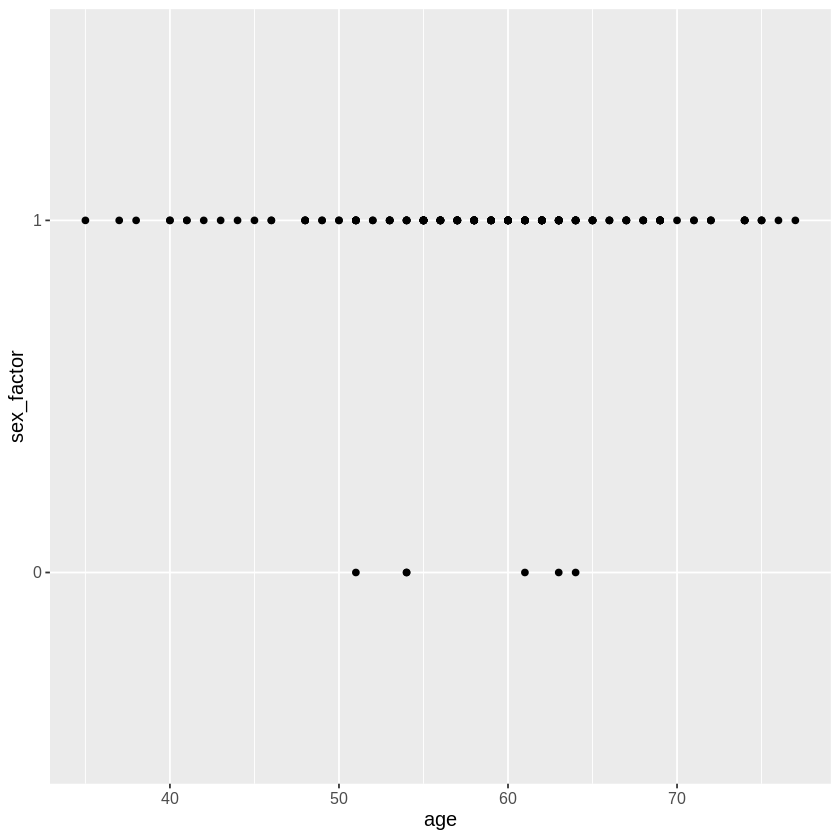

In [7]:
test_graph <- lonbeach_select |>
    ggplot(aes(x = age, y = sex_factor)) +
    geom_point() +
    theme(text = element_text(size = 12))

test_graph

In [ ]:
#Kevin Cell

In [ ]:
#Avery Cell

In [ ]:
#Crystal